In this exercise, we will work with the NDX100 index.
We will use a combination of AI calculations to forecast the index future price with LSTM.

Citations: 

[1] https://www.analyticsvidhya.com/blog/2021/05/stock-price-prediction-and-forecasting-using-stacked-lstm/

[2] https://github.com/devnson/Stock-Price-Prediction-StackedLSTM/blob/main/StockMarketPredictionForecasting.ipynb

[3] https://saifgazali.medium.com/tesla-stock-price-prediction-using-stacked-lstms-ae51ee23669f

In [299]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere
# import sys
# !{sys.executable} -m pip install xgboost sklearn pandas numpy==1.21.0 daal==2021.4.0 seaborn scipy matplotlib yfinance tensorflow

In [300]:
# import libraries
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import numpy as np
from numpy import array
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow.keras as keras
keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import random
random.seed(10)
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

# Loading the Data

In [301]:
asset = "^NDX"
data = yf.download(asset, start="2018-01-01")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,6431.589844,6513.020020,6417.750000,6511.339844,6511.339844,1914930000
2018-01-03,6520.029785,6579.250000,6519.259766,6575.799805,6575.799805,2166780000
2018-01-04,6595.750000,6603.169922,6576.919922,6584.580078,6584.580078,2098890000
2018-01-05,6613.129883,6654.979980,6605.029785,6653.290039,6653.290039,2020900000
2018-01-08,6651.680176,6680.319824,6649.200195,6676.629883,6676.629883,2051430000


In [302]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-03,12983.580078,13289.190430,12974.849609,13253.259766,13253.259766,5628590000
2022-08-04,13253.769531,13326.719727,13170.440430,13311.040039,13311.040039,5408540000
2022-08-05,13107.450195,13286.019531,13070.360352,13207.690430,13207.690430,4888110000
2022-08-08,13227.089844,13394.540039,13103.799805,13159.160156,13159.160156,5190590000
2022-08-09,13064.200195,13095.700195,12945.595703,13008.165039,13008.165039,776247034


In [303]:
data['ma_2'] = data['Close'].rolling(2).mean()

In [304]:
data['ma_2']

Date
2018-01-02             NaN
2018-01-03     6543.569824
2018-01-04     6580.189941
2018-01-05     6618.935059
2018-01-08     6664.959961
                  ...     
2022-08-03    13077.429688
2022-08-04    13282.149902
2022-08-05    13259.365234
2022-08-08    13183.425293
2022-08-09    13083.662598
Name: ma_2, Length: 1159, dtype: float64

In [305]:
data['dow'] = data.index.dayofweek
data['dow'].value_counts()

1    239
2    236
3    235
4    231
0    218
Name: dow, dtype: int64

In [306]:
data['dom'] = data.index.day
data['dom'].value_counts()

8     41
9     40
11    40
14    39
13    39
12    39
16    39
22    39
23    39
2     38
3     38
27    38
7     38
6     38
26    38
24    38
18    38
10    38
5     38
4     38
19    37
1     37
17    37
15    37
20    37
21    37
28    37
29    36
25    35
30    34
31    22
Name: dom, dtype: int64

In [307]:
# asset = "^NDX"
EURUSD = yf.download("EURUSD=X", start="2018-01-01")
EURUSD = EURUSD.rename(columns={'Close': 'EURUSD'})
data = data.merge(EURUSD['EURUSD'].fillna(method='pad'), how='left',left_index=True,right_index=True)

[*********************100%***********************]  1 of 1 completed


In [308]:
EURUSD.head()

,Open,High,Low,EURUSD,Adj Close,Volume
Date,,,,,,
2018-01-01,1.200495,1.201504,1.199904,1.200495,1.200495,0
2018-01-02,1.201086,1.208094,1.200855,1.201158,1.201158,0
2018-01-03,1.206200,1.206709,1.200495,1.206345,1.206345,0
2018-01-04,1.201129,1.209190,1.200495,1.201043,1.201043,0
2018-01-05,1.206622,1.208459,1.202154,1.206884,1.206884,0


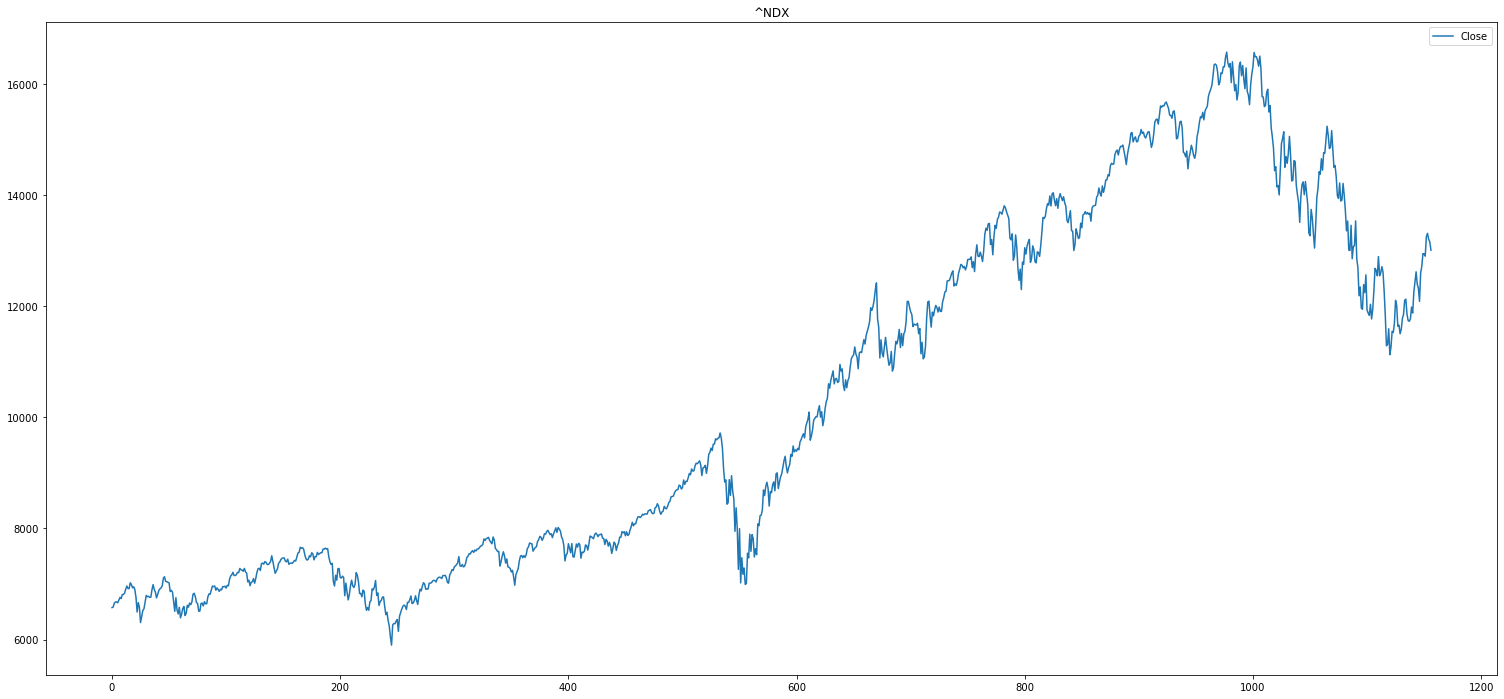

In [309]:
data=data.dropna().reset_index()
df1=data.reset_index()[['Close','ma_2']].fillna(method='pad')# ,'dow','dom','EURUSD'
n_features = df1.shape[1]
plt.figure(figsize=(26,12))
df1.Close.plot(title=asset,label='Close')
# df1.High.plot(title=asset,label='High')
# df1.Low.plot(title=asset,label='Low')
plt.legend(loc='best')
plt.show()

In [310]:
scaler_output = MinMaxScaler(feature_range=(0,1))
output=scaler_output.fit_transform(np.array(df1['Close']).reshape(-1,1))
output

array([[0.06337365],
       [0.06419624],
       [0.07063338],
       ...,
       [0.68468684],
       [0.68014025],
       [0.66599417]])

In [311]:
scaler=MinMaxScaler(feature_range=(0,1))
# df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1=scaler.fit_transform(np.array(df1))
df1

array([[0.06337365, 0.05406006],
       [0.06419624, 0.05752945],
       [0.07063338, 0.06120016],
       ...,
       [0.68468684, 0.69031473],
       [0.68014025, 0.68312018],
       [0.66599417, 0.67366866]])

In [312]:
training_size=int(df1.shape[0]*0.65)
test_size=df1.shape[0]-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:df1.shape[0],:]
train_data.shape, test_data.shape

((752, 2), (405, 2))

# Data Preprocessing

In [313]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(dataset.shape[0]-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((651, 100, 2), (651,), (304, 100, 2), (304,))

In [314]:
X_train

array([[[0.06337365, 0.05406006],
        [0.06419624, 0.05752945],
        [0.07063338, 0.06120016],
        ...,
        [0.09877092, 0.0900665 ],
        [0.09840276, 0.09272301],
        [0.09945389, 0.09306834]],

       [[0.06419624, 0.05752945],
        [0.07063338, 0.06120016],
        [0.07281999, 0.06556056],
        ...,
        [0.09840276, 0.09272301],
        [0.09945389, 0.09306834],
        [0.09623299, 0.09197124]],

       [[0.07063338, 0.06120016],
        [0.07281999, 0.06556056],
        [0.07294272, 0.06672823],
        ...,
        [0.09945389, 0.09306834],
        [0.09623299, 0.09197124],
        [0.10090135, 0.09270312]],

       ...,

       [[0.48301808, 0.47441307],
        [0.48690228, 0.48344464],
        [0.48960983, 0.48677761],
        ...,
        [0.64070041, 0.64159508],
        [0.636211  , 0.63866763],
        [0.6387686 , 0.63769085]],

       [[0.48690228, 0.48344464],
        [0.48960983, 0.48677761],
        [0.50287944, 0.4948561 ],
        .

# LSTM Model

In [315]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , n_features)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , n_features)

In [316]:
X_train

array([[[0.06337365, 0.05406006],
        [0.06419624, 0.05752945],
        [0.07063338, 0.06120016],
        ...,
        [0.09877092, 0.0900665 ],
        [0.09840276, 0.09272301],
        [0.09945389, 0.09306834]],

       [[0.06419624, 0.05752945],
        [0.07063338, 0.06120016],
        [0.07281999, 0.06556056],
        ...,
        [0.09840276, 0.09272301],
        [0.09945389, 0.09306834],
        [0.09623299, 0.09197124]],

       [[0.07063338, 0.06120016],
        [0.07281999, 0.06556056],
        [0.07294272, 0.06672823],
        ...,
        [0.09945389, 0.09306834],
        [0.09623299, 0.09197124],
        [0.10090135, 0.09270312]],

       ...,

       [[0.48301808, 0.47441307],
        [0.48690228, 0.48344464],
        [0.48960983, 0.48677761],
        ...,
        [0.64070041, 0.64159508],
        [0.636211  , 0.63866763],
        [0.6387686 , 0.63769085]],

       [[0.48690228, 0.48344464],
        [0.48960983, 0.48677761],
        [0.50287944, 0.4948561 ],
        .

In [317]:
model=Sequential()
# https://keras.io/api/layers/activations/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM 
# sigmoid by default
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,n_features))) #, activation='tanh'
# model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True)) #, activation='tanh'
model.add(LSTM(50))
model.add(Dense(1))
# https://keras.io/api/optimizers/
# model.compile(loss='mean_squared_error',optimizer='adam')# adaptive moment estimation GOOD
# model.compile(loss='mean_squared_error',optimizer='SGD')# Stochastic Gradient Descendent BAD
model.compile(loss='mean_squared_error',optimizer='RMSprop')# Root Mean Squared Propagation BEST
# model.compile(loss='mean_squared_error',optimizer='Adagrad')# Adaptive Gradient Algorithm VERY BAD
# model.compile(loss='mean_squared_error',optimizer='Adadelta')# adapts learning rates VERY BAD
# model.compile(loss='mean_squared_error',optimizer='Adamax')# Adam based on the infinity norm OK
# model.compile(loss='mean_squared_error',optimizer='Nadam')# Nesterov-accelerated Adaptive Moment Estimation OK
# model.compile(loss='mean_squared_error',optimizer='Ftrl')# Follow The Regularized Leader NA
# https://keras.io/api/losses/
# model.compile(loss='huber',optimizer='RMSprop')# OK
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10600     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51,051
Trainable params: 51,051
Non-trainable params: 0
_________________________________________________________________


In [318]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
11/11 [==============================] - 10s 270ms/step - loss: 0.0113 - val_loss: 0.0117
Epoch 2/100
11/11 [==============================] - 2s 141ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3/100
11/11 [==============================] - 1s 135ms/step - loss: 0.0040 - val_loss: 0.0229
Epoch 4/100
11/11 [==============================] - 2s 138ms/step - loss: 0.0024 - val_loss: 0.0128
Epoch 5/100
11/11 [==============================] - 2s 138ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 6/100
11/11 [==============================] - 1s 137ms/step - loss: 0.0025 - val_loss: 0.0072
Epoch 7/100
11/11 [==============================] - 2s 140ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 8/100
11/11 [==============================] - 2s 139ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 9/100
11/11 [==============================] - 2s 176ms/step - loss: 0.0014 - val_loss: 0.0275
Epoch 10/100
11/11 [==============================] - 1s 136ms/step - loss: 0.0018 - val_l

11/11 [==============================] - 2s 201ms/step - loss: 4.3106e-04 - val_loss: 0.0017
Epoch 80/100
11/11 [==============================] - 2s 183ms/step - loss: 4.7698e-04 - val_loss: 0.0016
Epoch 81/100
11/11 [==============================] - 2s 198ms/step - loss: 5.5837e-04 - val_loss: 0.0042
Epoch 82/100
11/11 [==============================] - 2s 189ms/step - loss: 3.0909e-04 - val_loss: 0.0169
Epoch 83/100
11/11 [==============================] - 2s 197ms/step - loss: 3.8531e-04 - val_loss: 0.0025
Epoch 84/100
11/11 [==============================] - 2s 198ms/step - loss: 4.6629e-04 - val_loss: 0.0046
Epoch 85/100
11/11 [==============================] - 2s 186ms/step - loss: 5.2709e-04 - val_loss: 0.0087
Epoch 86/100
11/11 [==============================] - 2s 195ms/step - loss: 3.5949e-04 - val_loss: 0.0027
Epoch 87/100
11/11 [==============================] - 2s 194ms/step - loss: 4.7503e-04 - val_loss: 0.0060
Epoch 88/100
11/11 [==============================] - 2s 19

In [319]:
y_train=scaler_output.inverse_transform(np.array(y_train).reshape(-1,1))
y_test=scaler_output.inverse_transform(np.array(y_test).reshape(-1,1))

In [320]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler_output.inverse_transform(train_predict)
test_predict=scaler_output.inverse_transform(test_predict)

10/10 [==============================] - 0s 23ms/step


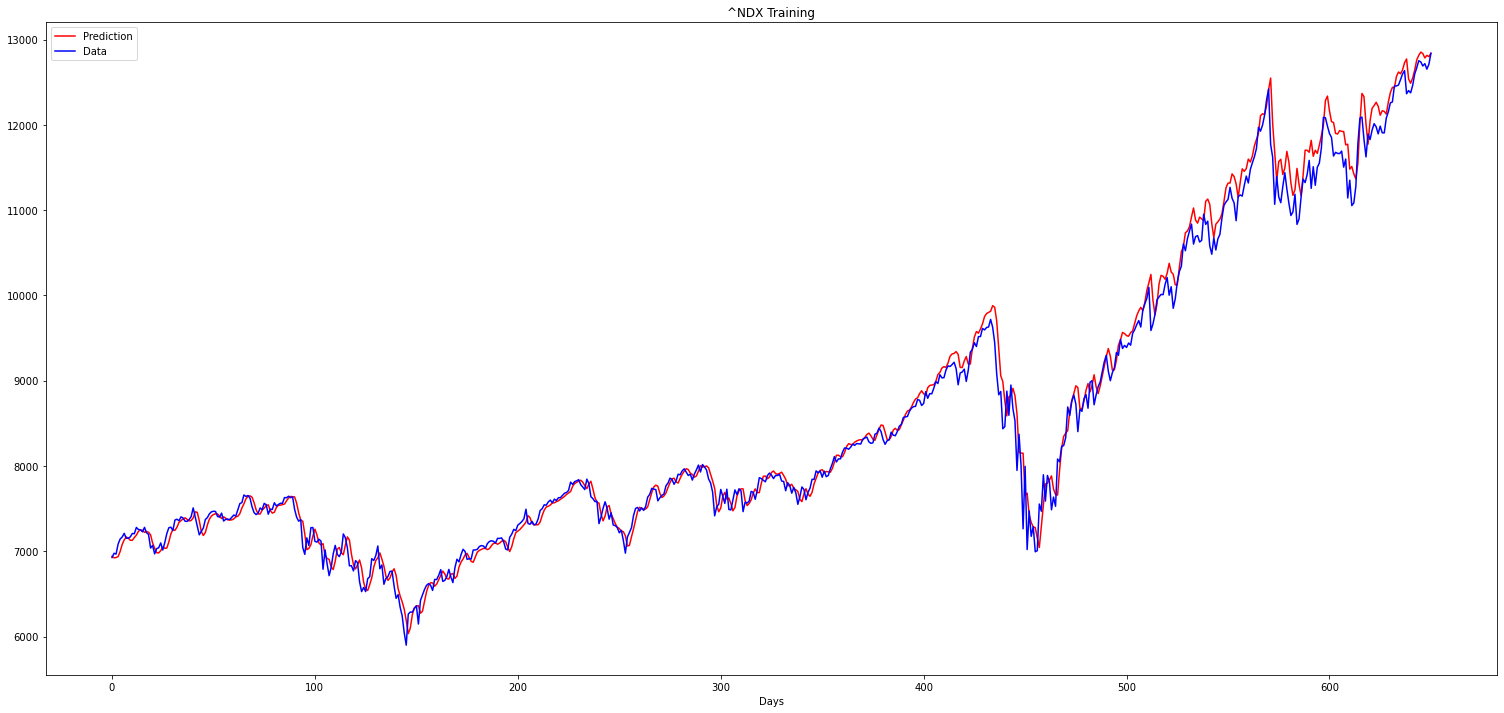

In [321]:
plt.figure(figsize=(26,12))
plt.plot(train_predict,color='red',label='Prediction')
plt.plot(y_train,color='blue',label='Data')
# plt.gca().xaxis.set_major_locator(years)
plt.xlabel('Days')
plt.title(asset+" Training")
plt.legend(loc='best')
plt.show()

In [322]:
round(math.sqrt(mean_squared_error(y_train,train_predict)),2)

172.92

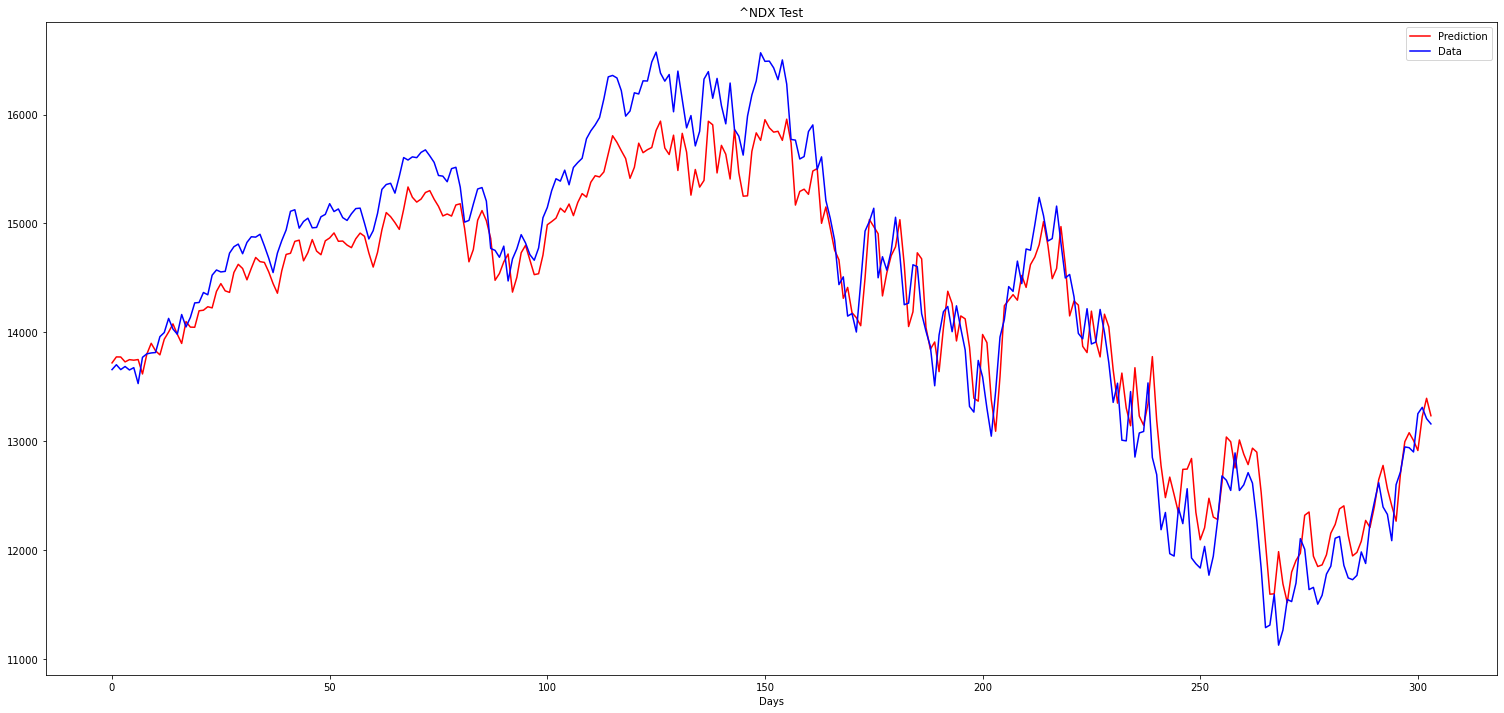

In [323]:
plt.figure(figsize=(26,12))
plt.plot(test_predict,color='red',label='Prediction')
plt.plot(y_test,color='blue',label='Data')
# plt.gca().xaxis.set_major_locator(years)
plt.xlabel('Days')
plt.title(asset+" Test")
plt.legend(loc='best')
plt.show()

In [324]:
round(math.sqrt(mean_squared_error(y_test, test_predict)),2)

369.74

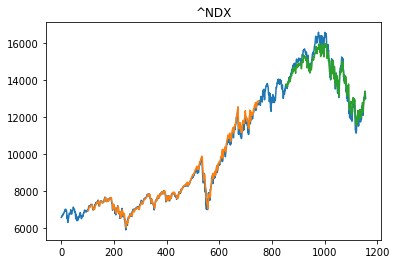

In [325]:
# Plotting
# Shift train predictionis for plotting

look_back = time_step
trainPredictPlot = np.empty_like(output)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back: train_predict.shape[0] + look_back, :] = train_predict


# Shif test prediction for plotting
testPredictPlot = np.empty_like(output)
testPredictPlot[:,:] = np.nan
testPredictPlot[train_predict.shape[0] + (look_back*2) + 1: df1.shape[0]-1,:] = test_predict


# plot baseline and predictions
plt.plot(scaler_output.inverse_transform(output))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title(asset)
plt.show()